In [13]:
import gdown
gdown.download_folder('https://drive.google.com/drive/folders/1xzLqyBRJn-NxbiQoRq3R4uDpyZKBXCK-?usp=drive_link',
                      output='../logs/report', quiet=True)

['../logs/report/errors.json',
 '../logs/report/pairings.json',
 '../logs/report/parser_config.json',
 '../logs/report/results.json']

In [2]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


sns.set_theme(
    context="paper",
    style="ticks",
    font_scale=1.2,
    rc={
        "figure.dpi": 300,
        "figure.constrained_layout.use": True,
        "lines.linewidth": 3,
        "figure.figsize": (4, 3), # (4x3 if 2-column, else 7x3.5)
    },
)

label_dict = {
    "lora": "LoRA",
    "vera": "VeRA",
    'dynalora': "DynaLoRA",
    "dinalora": "DinaLoRA"
}


def interpolate_to_same_length(array, length):
    """Saves the day when the array is not of the same length as the max length."""
    return np.interp(np.linspace(0, 1, length), np.linspace(0, 1, len(array)), array)


In [3]:
report_path = '../logs/report' if os.path.exists(
    '../logs/report') else '/content/report'  # colab mode
results_path = os.path.join(report_path, 'results.json')
pairings_path = os.path.join(report_path, 'pairings.json')
errors_path = os.path.join(report_path, 'errors.json')

with open(results_path) as f:
    results = json.load(f)
with open(pairings_path) as f:
    pairings = json.load(f)
with open(errors_path) as f:
    errors = json.load(f)

In [4]:
# initial cleaning of the data from unusable results.
# remove any experiment that does not have a measurements or an arguments field
todel = []
for job_id, job in results.items():
    for experiment_id, experiment in job.items():
        if ('No metrics' in errors[job_id][experiment_id]  # there is nothing to plot
                # likely no metrics then either
                or 'No log file' in errors[job_id][experiment_id]
                # likewise
            or 'could not read log file' in errors[job_id][experiment_id]
            or 'arguments' not in experiment  # can't categorize
            ):
            todel.append((job_id, experiment_id))
            # print('removed experiment', experiment_id, 'from job', job_id)
            # print('reason:', errors[job_id][experiment_id])
            # print('corresponding pairing:')
            # print('  ', pairings[job_id][experiment_id].get('directory', 'no directory'))
            # print('  ', pairings[job_id][experiment_id].get('logfile', 'no logfile'))
for job_id, experiment_id in todel:
    del results[job_id][experiment_id]
    if len(results[job_id]) == 0:
        del results[job_id]
    del errors[job_id][experiment_id]
    if len(errors[job_id]) == 0:
        del errors[job_id]
print('removed', len(todel), 'experiments, from', len(
    set([job_id for job_id, _ in todel])), 'jobs')

removed 205 experiments, from 76 jobs


In [5]:
print("number of jobs:", len(results))
print("number of experiments:", sum([len(job) for job in results.values()]))

number of jobs: 57
number of experiments: 414


In [6]:
print('Number of results:', len(results))
print('Number of pairings:', len(pairings))
print('Number of errors:', len(errors))

error_messages = set([e for job_e in errors.values()
                     for experiment_e in job_e.values() for e in experiment_e])
print('Unique error messages:', len(error_messages))
print('  -', '\n  - '.join(error_messages))
print('_________________________')
unique_keys = set([k for job in results.values()
                  for experiment in job.values() for k in experiment.keys()])
print('Unique keys:', len(unique_keys))
print('  -', '\n  - '.join(unique_keys))
# take out the arguments key from each experiment
argument_dict = {}
for job_id, job in results.items():
    argument_dict[job_id] = {}
    for experiment_id, experiment in job.items():
        argument_dict[job_id][experiment_id] = experiment.get('arguments')
        if 'arguments' in experiment:
            del experiment['arguments']
# it might be the case that ModelArguments is a key in the arguments dictionary
# we want to lift the elements of the ModelArguments dictionary to the top level
for job_id, job in argument_dict.items():
    for experiment_id, experiment in job.items():
        if 'ModelArguments' in experiment:
            experiment.update(experiment.pop('ModelArguments'))
print('_________________________')
unique_args = set([
    k for job in argument_dict.values()
    for experiment in job.values() for k in experiment.keys()])
print('Unique arguments:', len(unique_args))
print('  -', '\n  - '.join(unique_args))
# take measurements data from each experiment
measurements_dict = {}
for job_id, job in results.items():
    measurements_dict[job_id] = {}
    for experiment_id, experiment in job.items():
        measurements_dict[job_id][experiment_id] = experiment.get(
            'metrics', {})
unique_measuement_keys = set([
    k for job in measurements_dict.values()
    for experiment in job.values() for k in experiment.keys()])
print('_________________________')
print('Unique measurements:', len(unique_measuement_keys))
print('  -', '\n  - '.join(unique_measuement_keys))

Number of results: 57
Number of pairings: 119
Number of errors: 57
Unique error messages: 4
  - No directory
  - could not load dynalora_logs.json
  - No reallocs
  - No dynalora_logs.json
_________________________
Unique keys: 10
  - schedule
  - aggregate
  - allocator
  - arguments
  - metrics
  - adapter_base_names
  - num_params
  - cum_acts
  - masks
  - reallocs
_________________________
Unique arguments: 167
  - group_by_length
  - megatron_config
  - push_to_hub_organization
  - disable_tqdm
  - do_eval
  - logging_strategy
  - per_device_eval_batch_size
  - seed
  - logging_dir
  - save_on_each_node
  - fp16_opt_level
  - hub_private_repo
  - ray_scope
  - model_name
  - dataloader_num_workers
  - log_on_each_node
  - hub_strategy
  - run_name
  - dataloader_prefetch_factor
  - per_device_train_batch_size
  - ddp_bucket_cap_mb
  - hub_model_id
  - torchdynamo
  - data_seed
  - learning_rate
  - mp_parameters
  - adam_beta2
  - ddp_backend
  - save_strategy
  - d_initial
  - l

In [7]:
# build dataframes for the errors, arguments, and timeseries data
#  error header is job_id, experiment_id, error1, error2, ...
error_df = pd.DataFrame(data=[
    {'job_id': job_id, 'experiment_id': experiment_id,
        **{e: True for e in experiment_e}}
    for job_id, job_e in errors.items() for experiment_id, experiment_e in job_e.items()
], columns=['job_id', 'experiment_id'] + list(error_messages), dtype=bool)
error_df.fillna(value=False)
# fill the table row-by-row

# argument header is job_id, experiment_id, arg1, arg2, ...
flat_args = []
for job_id, job in argument_dict.items():
    for experiment_id, experiment in job.items():
        flat_args.append(
            {'job_id': job_id, 'experiment_id': experiment_id, **experiment})

print(len(flat_args))
arg_df = pd.DataFrame(
    data=flat_args,
    columns=['job_id', 'experiment_id'] + list(unique_args))
arg_df.fillna(value=np.nan, inplace=True)
# print the job id, experiment if and the experiment field if its not nan
# target_modules should default to ["query", "value"]
arg_df['target_modules'] = arg_df['target_modules'].apply(
    lambda x: x if x is not np.nan else ["query", "value"])
arg_df['allocator_type'] = arg_df['allocator_type'].apply(
    lambda x: x if x is not np.nan else "N/A")
arg_df['schedule_type'] = arg_df['schedule_type'].apply(
    lambda x: x if x is not np.nan else "N/A")

414


In [8]:
# unique task arguments
arg_df[["task"]].drop_duplicates()

,task
0,NaN
334,cola
352,rte
353,qnli
354,sst2
355,stsb
356,mrpc


In [9]:
modes = ['train', 'eval', 'test', 'grad']
# for each mode, collect merics that have 'mode' as a prefix in at least one of their keys
#  we assume the reported dictionaries for each experiment is uniquely identified by the mode
modes_metrics = {}  # for
for job_id, job in results.items():
    for experiment_id, experiment in job.items():
        modes_metrics[(job_id, experiment_id)] = {mode: {} for mode in modes}
        for metric_key, metrics in experiment['metrics'].items():
            for mode in modes:
                # metric key is a concatenation of the contained dictionaries' keys
                if metric_key.find(mode) != -1:
                    if len(modes_metrics[(job_id, experiment_id)][mode]) == 0:
                        modes_metrics[(job_id, experiment_id)][mode] = {
                            m: [] for m in metrics[0].keys()}
                    for metric in metrics:
                        for m_name, m in metric.items():
                            modes_metrics[(job_id, experiment_id)
                                          ][mode][m_name].append(m)
                    break
            else:
                print('No mode found for key', metric_key)

In [10]:
# EXTRACT DYNA METRICS
dyna_keys = [
    'adapter_base_names',
    'reallocs',
    'num_params',
    'masks',
    'cum_acts',  # NOTE: cum_acts may be a list or a dict. If its a dict, then it has two keys: acts and weights
    'acts',
    'weights'
]
if_dict_ca_keys = ['acts', 'weights']
dyna_dicts = {}
for job_id, job in results.items():
    for experiment_id, experiment in job.items():
        # if error_df.query(f'job_id == {job_id} && experiment_id == {experiment_id}')[['']]
        dyna_dicts[(job_id, experiment_id)] = {}
        for key in dyna_keys:
            if key in experiment:
                dyna_dicts[(job_id, experiment_id)][key] = experiment[key]
for key in dyna_dicts.keys():
    if ('cum_acts' in dyna_dicts[key] and
        len(dyna_dicts[key]['cum_acts']) > 0 and
            isinstance(dyna_dicts[key]['cum_acts'][0], dict)):
        acts, weights = [], []
        for act_wei in dyna_dicts[key]['cum_acts']:
            acts.append(act_wei['acts'])
            weights.append(act_wei['weights'])
        dyna_dicts[key].pop('cum_acts')
        dyna_dicts[key]['acts'] = acts
        dyna_dicts[key]['weights'] = weights

print(set([k for v in dyna_dicts.values() for k in v.keys()]))

{'reallocs', 'acts', 'cum_acts', 'adapter_base_names', 'num_params', 'weights', 'masks'}


## Loss computation 

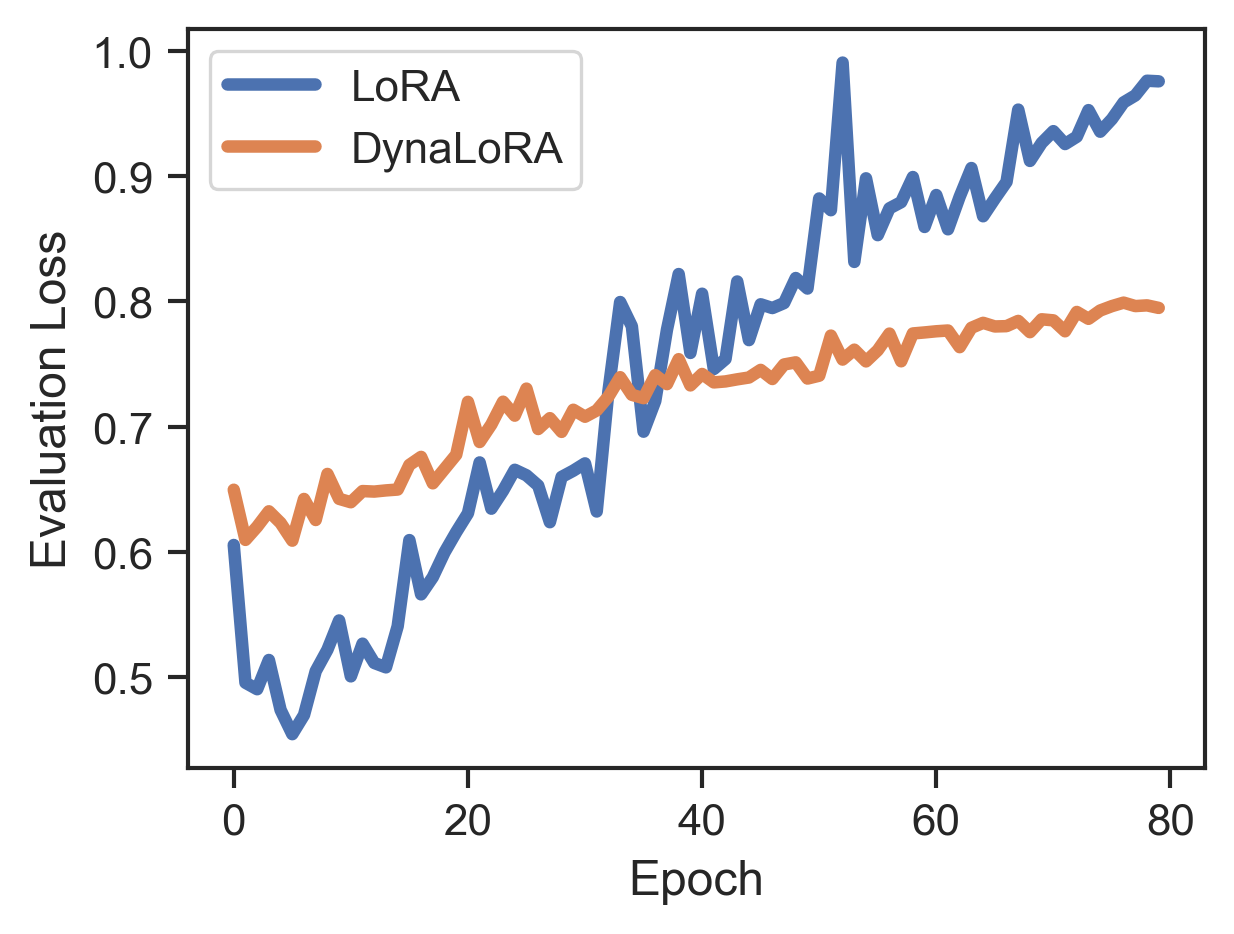

In [11]:
def get_mean_loss(lora_losses):
    max_length = max([len(row['eval']['eval_loss']) for idx, row in lora_losses.iterrows()])
    return np.mean([interpolate_to_same_length(row['eval_loss'], max_length) for row in lora_losses['eval']], axis=0)

metrics = pd.DataFrame(modes_metrics).T

for lora in label_dict: # NOTE: Might want to include DynaVera
    # Let me show you some magic instead of the above ^
    index = arg_df[(arg_df['lora'] == lora) & (
        arg_df['task'] == 'cola')][['job_id', 'experiment_id']]

    lora_losses = metrics.loc[index.values.tolist()]
    lora_losses = lora_losses.reset_index()
    
    if len(lora_losses) == 0:
        continue

    lora_mean = get_mean_loss(lora_losses)
    plt.plot(lora_mean, label=label_dict[lora])
    
    # lora_losses['eval'][0]['eval_loss']
plt.xlabel('Epoch')
plt.ylabel('Evaluation Loss')
plt.legend()


In [25]:
cola_experiments = pd.read_csv('../logs/report/cola_merged.csv', index_col=0)
cola_experiments = cola_experiments[(cola_experiments['lora'] == 'dynalora') & (cola_experiments['max_eval_matthews'] > 0.05)]



display(cola_experiments.sort_values(by=['allocator_type', 'schedule_type']))

,job_id,experiment_id,lora,task,batch_size,epochs,allocator_type,schedule_type,use_layerwise_optim,max_eval_loss,max_eval_matthews
6,6323354,11,dynalora,cola,32.0,80.0,threshold;0.05,once;3,False,0.525861,0.306427
0,6323354,10,dynalora,cola,32.0,80.0,threshold;0.1,once;3,False,0.509063,0.519094
20,6329466,10,dynalora,cola,32.0,80.0,threshold;0.1,once;3,False,0.505158,0.523864
16,6329466,9,dynalora,cola,32.0,80.0,threshold;0.2,once;3,False,0.654417,0.582921
21,6329466,8,dynalora,cola,32.0,80.0,threshold;0.3,once;3,False,0.964496,0.595816
1,6323354,8,dynalora,cola,32.0,80.0,threshold;0.3,periodic;100,False,1.018106,0.575301
14,6329466,7,dynalora,cola,32.0,80.0,threshold;0.4,once;3,False,1.277029,0.560465
4,6323354,7,dynalora,cola,32.0,80.0,threshold;0.4,periodic;100,False,1.296715,0.590841
19,6329466,6,dynalora,cola,32.0,80.0,threshold;0.5,once;3,False,1.332312,0.581202
2,6323354,6,dynalora,cola,32.0,80.0,threshold;0.5,periodic;100,False,1.438615,0.558210
